In [1]:
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import xgboost as xgb
import warnings

warnings.filterwarnings('ignore')

## Read Train Data

In [2]:
# Read training inputs
train_home_team_statistics_df = pd.read_csv('../Train_Data/train_home_team_statistics_df.csv', index_col=0)
train_away_team_statistics_df = pd.read_csv('../Train_Data/train_away_team_statistics_df.csv', index_col=0)

# Read training labels
train_labels = pd.read_csv('../Y_train.csv', index_col=0)

# Remove league and team name, we want to generalize the results
train_home = train_home_team_statistics_df.iloc[:,2:]
train_away = train_away_team_statistics_df.iloc[:,2:]

# Designate home and away columns
train_home.columns = 'HOME_' + train_home.columns
train_away.columns = 'AWAY_' + train_away.columns

# Concatenate home and away data
train_data =  pd.concat([train_home, train_away], join='inner', axis=1)
train_data = train_data.replace({np.inf:np.nan, -np.inf:np.nan})

In [3]:
# Combine home-win, draw, and away-win columns into one
train_labels = train_labels.loc[train_data.index]
train_labels = pd.from_dummies(train_labels).rename(columns={"": "Results"})

# Then, we want to change the strings into labels
train_labels["Labels"] = LabelEncoder().fit_transform(train_labels)

## Problem Description
The target score is the accuracy of prediction for the vector `[HOME_WINS, DRAW, AWAY_WINS]`, for which there are three possible choices, `[1,0,0]`, `[0,1,0]`, and `[0,0,1]`. Here we use an 80-20 train test split.

In [4]:
# 80-20 Train and Test Split
X_train, X_test, y_train, y_test = model_selection.train_test_split(train_data, train_labels["Labels"], train_size=0.8, random_state=42)

## XGBoost Model Training
Here, we use an XGBoost model, as it already has a built-in implementation to deal with NaN values. This yields better results when compared with imputation methods.

In [5]:
GRID =  {
	'eval_metric': ['mlogloss'],
	'objective': ['multi:softmax'],
	'num_class' :[3],
	'gamma' : [0, 0.25, 0.5],
	'alpha': [0, 0.5, 1],
  	'lambda' : [0.75, 1.25, 1.75],
  	'max_depth': [2, 3],
	'min_child_weight': [0.75, 1, 1.25]
  }

# Run grid search to look for the best parameters
grid_search = GridSearchCV(
  					estimator=xgb.XGBClassifier(random_state=1),
                    param_grid=GRID, 
                    scoring="accuracy", 
                    n_jobs=-1, 
           			cv=10,
          			refit=True,
          			verbose=10, 
                    return_train_score=False
          		)

# Train the model
grid_search.fit(X_train, y_train)

# Final model
final_model = xgb.XGBClassifier(**grid_search.best_params_) # Unpack dictionary
final_model.fit(X_train, y_train)

Fitting 10 folds for each of 162 candidates, totalling 1620 fits
[CV 2/10; 1/162] START alpha=0, eval_metric=mlogloss, gamma=0, lambda=0.75, max_depth=2, min_child_weight=0.75, num_class=3, objective=multi:softmax
[CV 1/10; 1/162] START alpha=0, eval_metric=mlogloss, gamma=0, lambda=0.75, max_depth=2, min_child_weight=0.75, num_class=3, objective=multi:softmax
[CV 3/10; 1/162] START alpha=0, eval_metric=mlogloss, gamma=0, lambda=0.75, max_depth=2, min_child_weight=0.75, num_class=3, objective=multi:softmax
[CV 5/10; 1/162] START alpha=0, eval_metric=mlogloss, gamma=0, lambda=0.75, max_depth=2, min_child_weight=0.75, num_class=3, objective=multi:softmax
[CV 4/10; 1/162] START alpha=0, eval_metric=mlogloss, gamma=0, lambda=0.75, max_depth=2, min_child_weight=0.75, num_class=3, objective=multi:softmax
[CV 6/10; 1/162] START alpha=0, eval_metric=mlogloss, gamma=0, lambda=0.75, max_depth=2, min_child_weight=0.75, num_class=3, objective=multi:softmax
[CV 8/10; 1/162] START alpha=0, eval_metr

XGBClassifier(alpha=0, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None, lambda=1.75,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=0.75, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, ...)

## Feature Importance

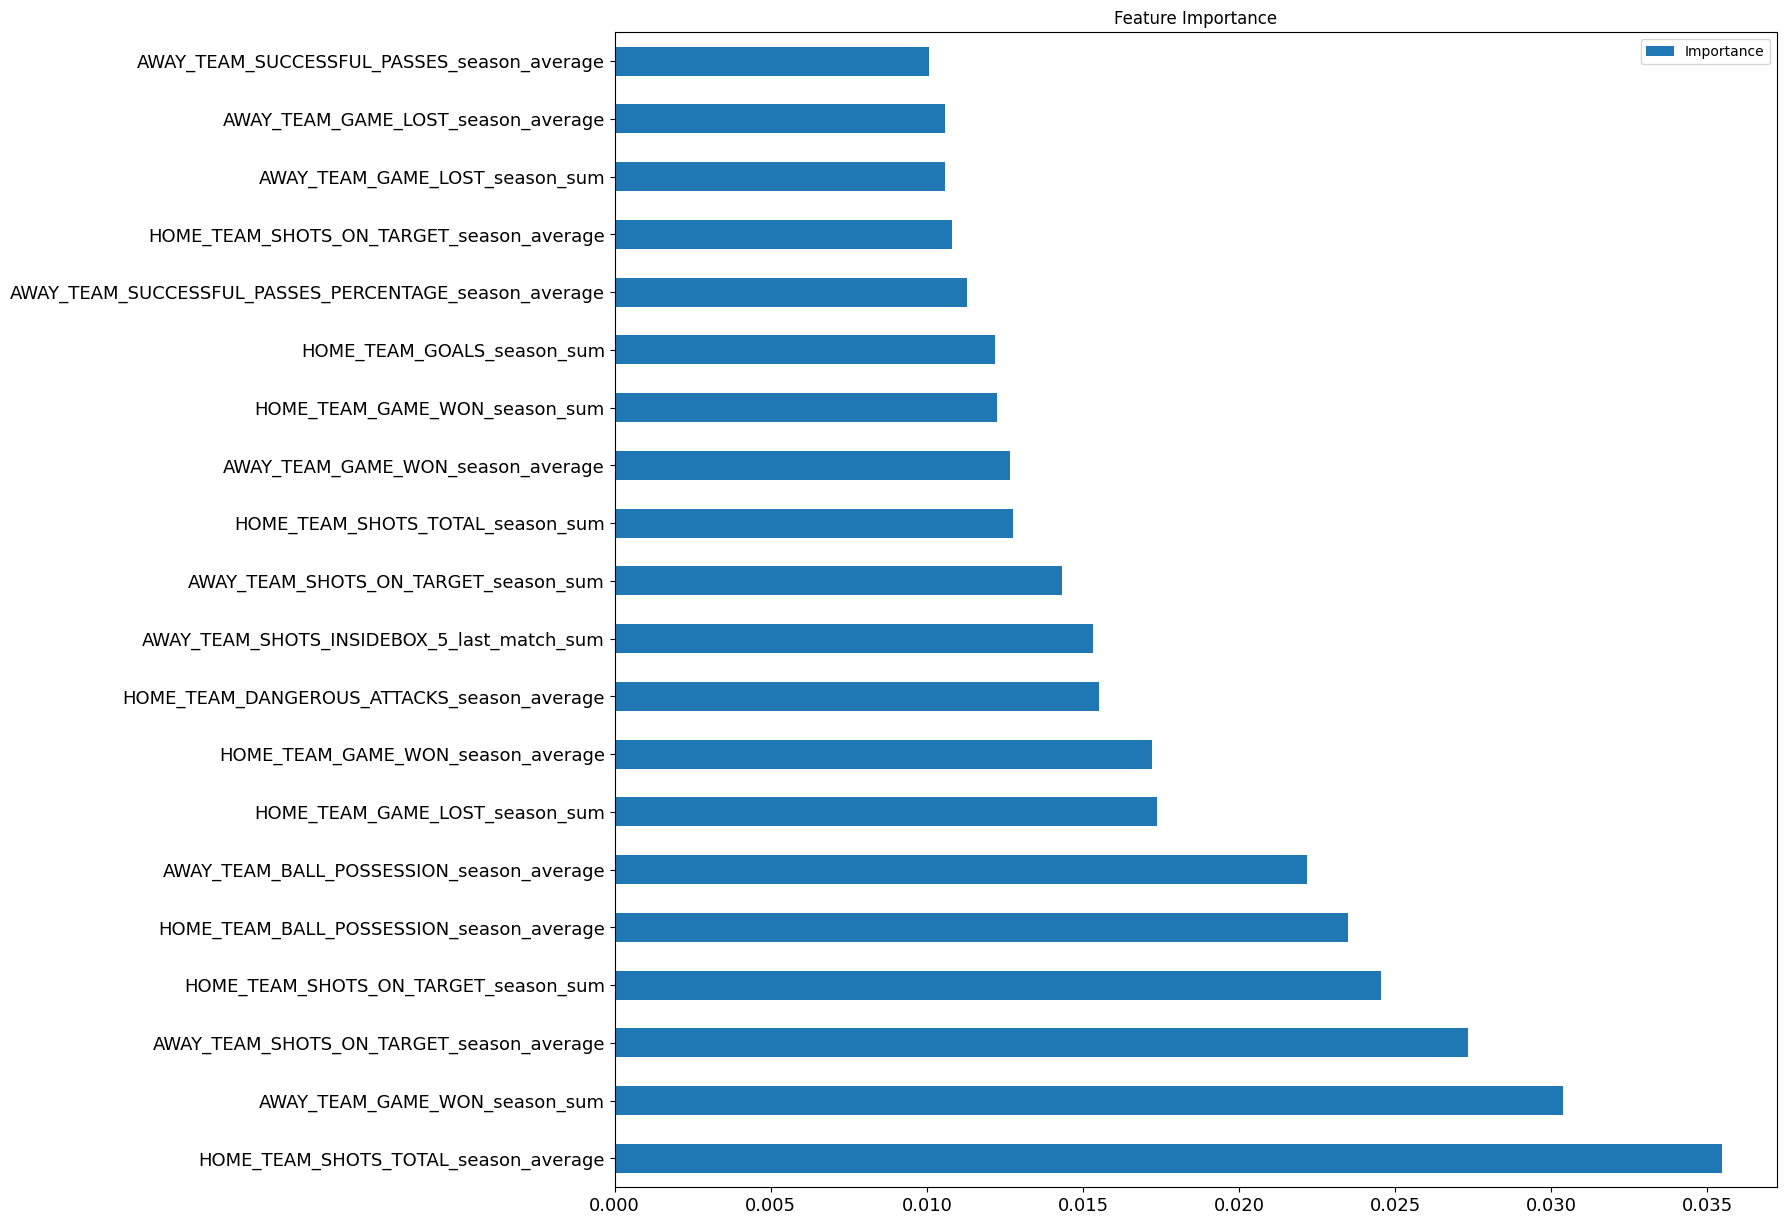

In [6]:
fi = pd.DataFrame(data = final_model.feature_importances_, index = final_model.feature_names_in_, columns = ['Importance'])
fi.nlargest(20, 'Importance').plot(kind = 'barh', title = 'Feature Importance', fontsize = 13, figsize = (15,15))
plt.show()

## Accuracy on Private Test Set

In [7]:
# Make predictions, ordered by row
predictions = pd.DataFrame(final_model.predict(X_test))

# Accuracy
print(np.round(accuracy_score(predictions, y_test), 4))

0.4925


## Reading Public Test Set

In [8]:
# Read test set
test_home = pd.read_csv('../Test_Data/test_home_team_statistics_df.csv', index_col=0)
test_away = pd.read_csv('../Test_Data/test_away_team_statistics_df.csv', index_col=0)

# Read public test labels
test_labels = pd.read_csv('../Y_test.csv', index_col=0)

# Change column names
test_home.columns = 'HOME_' + test_home.columns
test_away.columns = 'AWAY_' + test_away.columns

# Basic data cleaning
test_data =  pd.concat([test_home,test_away], join='inner', axis=1)
test_data = test_data.replace({np.inf:np.nan, -np.inf:np.nan})

In [9]:
# Combine home-win, draw, and away-win columns into one
test_labels = test_labels.loc[test_data.index]
test_labels = pd.from_dummies(test_labels).rename(columns={"": "Results"})

# Then, we want to change the strings into labels
test_labels["Labels"] = LabelEncoder().fit_transform(test_labels)

## Accuracy on Public Test Set

In [10]:
# Make predictions, ordered by row
public_predictions = pd.DataFrame(final_model.predict(test_data))

# Accuracy
print(np.round(accuracy_score(public_predictions, test_labels["Labels"]), 4))

0.3327


## Reversing the Label Encodings

In [11]:
label_encoding_dict = {
    'AWAY_WINS': 0,
    'DRAW': 1,
    'HOME_WINS': 2,
}

# Function to perform inverse label encoding
def inverse_label_encoding(encoded_labels, label_encoding_dict):

    # Create a reverse dictionary to map encoded values to original labels
    reverse_encoding_dict = {v: k for k, v in label_encoding_dict.items()}
    
    # Use the reverse dictionary to decode the labels
    original_labels = [reverse_encoding_dict[encoded_label] for encoded_label in encoded_labels]
    
    return original_labels

## Submission

In [12]:
# One hot encode the previous labels
submission = public_predictions.apply(lambda row: inverse_label_encoding(row, label_encoding_dict))

# Rename columns to match desired format
submission = pd.get_dummies(submission).rename(columns={'0_AWAY_WINS': 'AWAY_WINS',
                                           				'0_HOME_WINS': 'HOME_WINS',
                       					   				'0_DRAW': 'DRAW'})
# Reorder columns
submission = submission[['HOME_WINS', 'DRAW', 'AWAY_WINS']]

# Add the IDs of the test data
submission.index = test_data.index

# Change booleans to integers
submission = submission * 1

# Save the submission file
submission.to_csv('./submission.csv', index=True)